In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/helmet-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\jarif\.cache\kagglehub\datasets\andrewmvd\helmet-detection\versions\1


In [4]:
import os
import xml.etree.ElementTree as ET

# Set paths
input_dir = "data/annotations"  # folder with XML files
output_dir = "data/labels"      # where .txt label files will go

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

class_mapping = {
    "With Helmet": 0,
    "Without Helmet": 1,
    "Head": 2
}

for xml_file in os.listdir(input_dir):
    if not xml_file.endswith(".xml"):
        continue

    tree = ET.parse(os.path.join(input_dir, xml_file))
    root = tree.getroot()

    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    yolo_lines = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_mapping:
            continue
        class_id = class_mapping[class_name]

        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / width
        y_center = (ymin + ymax) / 2 / height
        box_width = (xmax - xmin) / width
        box_height = (ymax - ymin) / height

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}")

    # Write to label file
    output_file = os.path.join(output_dir, xml_file.replace(".xml", ".txt"))
    with open(output_file, "w") as f:
        f.write("\n".join(yolo_lines))


In [5]:
import os
import shutil
import random

image_dir = "data/images"
label_dir = "data/labels"

train_img_dir = "data/images/train"
val_img_dir = "data/images/val"
train_lbl_dir = "data/labels/train"
val_lbl_dir = "data/labels/val"

# Create folders
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Get all image names
image_files = [f for f in os.listdir(image_dir) if f.endswith(".png") or f.endswith(".jpg")]
random.shuffle(image_files)

# 80-20 train-val split
split_idx = int(0.8 * len(image_files))
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

def move_files(file_list, img_dst, lbl_dst):
    for file in file_list:
        img_src = os.path.join(image_dir, file)
        lbl_src = os.path.join(label_dir, file.replace(".png", ".txt").replace(".jpg", ".txt"))

        if os.path.exists(lbl_src):
            shutil.copy(img_src, os.path.join(img_dst, file))
            shutil.copy(lbl_src, os.path.join(lbl_dst, os.path.basename(lbl_src)))

move_files(train_files, train_img_dir, train_lbl_dir)
move_files(val_files, val_img_dir, val_lbl_dir)


In [7]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml')
model.model.nc = 3
model.model.names = ['With Helmet', 'Without Helmet', 'Head']
# Now train it with your dataset
model.train(data='data/data.yaml', epochs=25, imgsz=640)

Ultralytics 8.3.154  Python-3.10.18 torch-2.1.0+cpu CPU (12th Gen Intel Core(TM) i5-12500H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train16, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

train: Scanning C:\Users\jarif\Documents\helmet_detection\data\labels\train... 611 images, 2 backgrounds, 12 corrupt: 100%|██████████| 611/611 [00:01<00:00, 424.70it/s]

train: C:\Users\jarif\Documents\helmet_detection\data\images\train\BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: C:\Users\jarif\Documents\helmet_detection\data\images\train\BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: C:\Users\jarif\Documents\helmet_detection\data\images\train\BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: C:\Users\jarif\Documents\helmet_detection\data\images\train\BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: C:\Users\jarif\Documents\helmet_detection\data\images\train\BikesHelmets343.png: ignoring corrupt image/label: non-normalized or out of bounds co

val: Fast image access  (ping: 0.10.1 ms, read: 37.214.2 MB/s, size: 564.8 KB)


val: Scanning C:\Users\jarif\Documents\helmet_detection\data\labels\val... 153 images, 1 backgrounds, 3 corrupt: 100%|██████████| 153/153 [00:00<00:00, 455.36it/s]

val: C:\Users\jarif\Documents\helmet_detection\data\images\val\BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
val: C:\Users\jarif\Documents\helmet_detection\data\images\val\BikesHelmets616.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        750       297.5          68          91]
val: C:\Users\jarif\Documents\helmet_detection\data\images\val\BikesHelmets80.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      424.5      45.298          71      82.631]
val: New cache created: C:\Users\jarif\Documents\helmet_detection\data\labels\val.cache


Plotting labels to C:\Users\jarif\runs\detect\train16\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\jarif\runs\detect\train16
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      4.063      5.317      4.195         21        640: 100%|██████████| 38/38 [02:48<00:00,  4.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

                   all        150        290   4.51e-05    0.00236    2.3e-05   6.88e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25         0G      3.414      4.502      3.647         27        640: 100%|██████████| 38/38 [02:56<00:00,  4.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

                   all        150        290   0.000225    0.00943   0.000116   2.87e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25         0G      2.838      4.087      2.933         20        640: 100%|██████████| 38/38 [02:41<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

                   all        150        290     0.0172    0.00943    0.00527    0.00213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25         0G       2.59      3.502      2.538         17        640: 100%|██████████| 38/38 [02:43<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

                   all        150        290     0.0532      0.178     0.0384      0.012

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/25         0G      2.442      3.092      2.362         16        640: 100%|██████████| 38/38 [03:24<00:00,  5.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

                   all        150        290      0.104      0.384      0.116     0.0482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25         0G      2.321      2.929      2.206         33        640: 100%|██████████| 38/38 [02:56<00:00,  4.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

                   all        150        290      0.244      0.283      0.204     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25         0G      2.211       2.64      2.126         20        640: 100%|██████████| 38/38 [02:56<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

                   all        150        290      0.279      0.366      0.275      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25         0G      2.109      2.353      1.993         19        640: 100%|██████████| 38/38 [02:55<00:00,  4.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

                   all        150        290      0.328      0.314      0.316      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25         0G      2.049      2.267      1.938         35        640: 100%|██████████| 38/38 [03:04<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

                   all        150        290       0.38      0.465      0.399      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25         0G      1.968      2.113      1.889         28        640: 100%|██████████| 38/38 [03:07<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

                   all        150        290      0.414       0.44      0.392      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25         0G      1.942          2      1.842         15        640: 100%|██████████| 38/38 [03:09<00:00,  4.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

                   all        150        290      0.406      0.442      0.396      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25         0G      1.932      1.951      1.831         19        640: 100%|██████████| 38/38 [03:08<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

                   all        150        290      0.515      0.486       0.47      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25         0G      1.958      1.946      1.862         19        640: 100%|██████████| 38/38 [03:08<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

                   all        150        290      0.514      0.478      0.507      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25         0G      1.869       1.85      1.759         33        640: 100%|██████████| 38/38 [03:09<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

                   all        150        290      0.477       0.53      0.502      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25         0G      1.769      1.721      1.701         25        640: 100%|██████████| 38/38 [03:08<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

                   all        150        290      0.623      0.506      0.554      0.315


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25         0G       1.68      1.744      1.685         11        640: 100%|██████████| 38/38 [03:06<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

                   all        150        290      0.532      0.541       0.53      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25         0G      1.665       1.68      1.677         15        640: 100%|██████████| 38/38 [03:04<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

                   all        150        290      0.561      0.472      0.531      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25         0G      1.633      1.587      1.662         11        640: 100%|██████████| 38/38 [04:15<00:00,  6.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]

                   all        150        290      0.567      0.509      0.538      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25         0G      1.613       1.56      1.658         10        640: 100%|██████████| 38/38 [23:18<00:00, 36.80s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]

                   all        150        290      0.631      0.568       0.59      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/25         0G      1.594      1.499      1.625         11        640: 100%|██████████| 38/38 [02:38<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

                   all        150        290      0.523      0.608      0.596      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25         0G      1.569      1.484      1.593         11        640: 100%|██████████| 38/38 [02:42<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

                   all        150        290      0.553      0.593      0.586      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25         0G      1.543      1.429      1.577          8        640: 100%|██████████| 38/38 [02:41<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

                   all        150        290      0.607      0.596      0.616      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25         0G       1.55      1.427      1.575          8        640: 100%|██████████| 38/38 [02:41<00:00,  4.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.83s/it]

                   all        150        290      0.582      0.629      0.611      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/25         0G      1.527      1.372      1.573         14        640: 100%|██████████| 38/38 [02:42<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

                   all        150        290      0.596      0.612      0.613       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25         0G      1.545      1.366      1.585         11        640: 100%|██████████| 38/38 [02:42<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]

                   all        150        290      0.588      0.648      0.613      0.349

25 epochs completed in 1.694 hours.


Optimizer stripped from C:\Users\jarif\runs\detect\train16\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\jarif\runs\detect\train16\weights\best.pt, 6.2MB

Validating C:\Users\jarif\runs\detect\train16\weights\best.pt...
Ultralytics 8.3.154  Python-3.10.18 torch-2.1.0+cpu CPU (12th Gen Intel Core(TM) i5-12500H)
YOLOv8n summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


                   all        150        290      0.607      0.596      0.617      0.352
           With Helmet        119        212       0.69      0.757      0.765      0.453
        Without Helmet         39         78      0.523      0.436      0.468      0.251
Speed: 1.2ms preprocess, 69.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to C:\Users\jarif\runs\detect\train16


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000017E4B38C880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0


image 1/1 C:\Users\jarif\Documents\projects\helmet_detection\data\images\BikesHelmets5.png: 416x640 1 Without Helmet, 140.0ms
Speed: 4.4ms preprocess, 140.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
Prediction saved to prediction_output.jpg


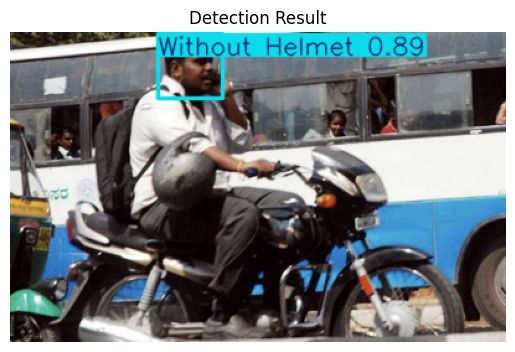

In [2]:
from ultralytics import YOLO
import os
import cv2
from matplotlib import pyplot as plt

# Load the trained YOLOv8 model (adjust path if needed)
model_path = r'C:\Users\jarif\runs\detect\train16\weights\best.pt'
assert os.path.exists(model_path), f"Model file not found: {model_path}"

model = YOLO(model_path)

# Path to your test image (adjust as needed)
img_path = r'C:\Users\jarif\Documents\projects\helmet_detection\data\images\BikesHelmets5.png'
assert os.path.exists(img_path), f"Image file not found: {img_path}"

# Run inference
results = model(img_path)

# Show result in a pop-up window (optional)
results[0].show()

# Save the result to a file
results[0].save(filename='prediction_output.jpg')
print("Prediction saved to prediction_output.jpg")

# Optional: Display result inline (e.g., in Jupyter Notebook or VSCode)
img_with_boxes = results[0].plot()

# Convert BGR to RGB for matplotlib display
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

# Plot the result
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Detection Result")
plt.show()


In [ ]:
# real time detection
from ultralytics import YOLO
import cv2

# Load the trained YOLOv8 model
model = YOLO(r"C:\Users\jarif\runs\detect\train16\weights\best.pt")  # Replace with your best.pt path

# Class names from your YAML
names = model.names  # {0: 'With Helmet', 1: 'Without Helmet', 2: 'Head'}

# Start webcam
cap = cv2.VideoCapture(0)  # Use 0 for default camera

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Run YOLOv8 inference
    results = model.predict(source=frame, show=False, stream=False, verbose=False)

    # Extract class ids
    class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    detected_classes = [names[c] for c in class_ids]

    # Logic to display helmet status
    status = "No Detection"
    if 0 in class_ids:
        status = " Wearing Helmet"
    elif 1 in class_ids:
        status = " Without Helmet"
    elif 2 in class_ids:
        status = " Head Detected (No Helmet)"

    # Draw results on frame
    annotated_frame = results[0].plot()
    cv2.putText(annotated_frame, status, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow("Helmet Detection", annotated_frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
cv2.destroyAllWindows()


: 